In [101]:
import sqlite3
import pandas as pd
import numpy as np
from scipy.stats import skew
import pgeocode

In [102]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

In [103]:
db = sqlite3.connect('home_sales.db')
df = pd.read_sql_query('SELECT * FROM sales;',db)

In [104]:
# dropping null values
df = df.dropna()

In [105]:
# feature engineering place_name from zipcode
nomi = pgeocode.Nominatim('us')
for index, row in df.iterrows():
    locObj = nomi.query_postal_code(int(row['zipcode']))
    df.loc[index,'place_name'] = locObj.place_name
df = df.replace({'place_name': {'Auburn':1,'Federal Way':2,'Kent':3,'Enumclaw':4,'Maple Valley':5,'Renton':6,'Black Diamond':7,'North Bend':8,'Duvall':9,'Carnation':10,'Kenmore':11,'Seattle':12,'Fall City':13,'Bothell':14,'Vashon':15,'Snoqualmie':16,'Kirkland':17,'Issaquah':18,'Woodinville':19,'Redmond':20,'Sammamish':21,'Bellevue':22,'Mercer Island':23,'Medina':24}
})

In [106]:
# relabel condition feature
df.loc[df.condition == 'TERRIBLE'] = df.loc[df.condition == 'TERRIBLE'].replace("TERRIBLE","0")
df.loc[df.condition == 'terrible'] = df.loc[df.condition == 'terrible'].replace("terrible","0")
df.loc[df.condition == 'POOR'] = df.loc[df.condition == 'POOR'].replace("POOR","1")
df.loc[df.condition == 'poor'] = df.loc[df.condition == 'poor'].replace("poor","1")
df.loc[df.condition == 'FAIR'] = df.loc[df.condition == 'FAIR'].replace("FAIR","2")
df.loc[df.condition == 'fair'] = df.loc[df.condition == 'fair'].replace("fair","2")
df.loc[df.condition == 'GOOD'] = df.loc[df.condition == 'GOOD'].replace("GOOD","3")
df.loc[df.condition == 'good'] = df.loc[df.condition == 'good'].replace("good","3")
df.loc[df.condition == 'EXCELLENT'] = df.loc[df.condition == 'EXCELLENT'].replace("EXCELLENT","4")
df.loc[df.condition == 'excellent'] = df.loc[df.condition == 'excellent'].replace("excellent","4")

In [107]:
# convert object to int
df['condition'] = df['condition'].astype(str).astype(int)

In [108]:
# dropping unnecessary features
df = df[['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition','review_score', 'basement_size', 'built', 'renovation','living_room_size', 'lot_size','place_name','latitude']]

In [109]:
df_hold = df

In [152]:
# Separate dataset into X and y
y_bin = df['price']
df = df.drop(columns=['price'])

In [153]:
# Log transform on X dataset for features with skewness >0.5
skewness = df.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness) + " skewed numerical features to log transform")
skewed_features = skewness.index
df[skewed_features] = np.log1p(df[skewed_features])

bedrooms             0.504491
bathrooms            0.523822
floors               0.616411
waterfront          10.922177
view                 3.389588
condition            1.023148
review_score         0.784347
basement_size        1.609070
renovation           4.483678
living_room_size     1.107078
lot_size             9.648442
dtype: float64 skewed numerical features to log transform


In [155]:
# create variable bins
bins = pd.IntervalIndex.from_tuples([(0, 3.230000e+05), (3.230001e+05, 4.520000e+05), (4.520001e+05, 6.500000e+05),(6.500001e+05,8.00000e+06)])
y_bint = pd.cut(y_bin, bins).cat.codes.to_numpy()

In [157]:
# Partition the dataset in train + test sets
X_train, X_test, y_train, y_test = train_test_split(df, y_bint, test_size = 0.5, random_state = 0)

In [158]:
# Transform features by standardization
# stdSc = StandardScaler()
# X_train = np.absolute(stdSc.fit_transform(X_train))
# X_test = np.absolute(stdSc.transform(X_test))

In [159]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [160]:
# testing classification model GaussianNB
a = X_test.shape[0]
b = (y_test != y_pred).sum()
c = 1 - b/a
print("Number of mislabeled points out of a total",a,"points :", b, "accuracy of ", c)

Number of mislabeled points out of a total 9844 points : 4428 accuracy of  0.5501828524989841


In [164]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
y_pred = mnb.fit(X_train, y_train).predict(X_test)

In [165]:
# testing classification model MultinomialNB
a = X_test.shape[0]
b = (y_test != y_pred).sum()
c = 1 - b/a
print("Number of mislabeled points out of a total",a,"points :", b, "accuracy of ", c)

Number of mislabeled points out of a total 9844 points : 5343 accuracy of  0.4572328321820398


In [166]:
from sklearn.svm import SVC
svc = SVC(gamma='auto')
y_pred = svc.fit(X_train, y_train).predict(X_test)

In [172]:
# testing classification model SVC
a = X_test.shape[0]
b = (y_test != y_pred).sum()
c = 1 - b/a
print("Number of mislabeled points out of a total",a,"points :", b, "accuracy of ", c)

Number of mislabeled points out of a total 9844 points : 4130 accuracy of  0.5804550995530272


Text(0.5, 1.0, 'Normalized Confusion Matrix for GaussianNB')

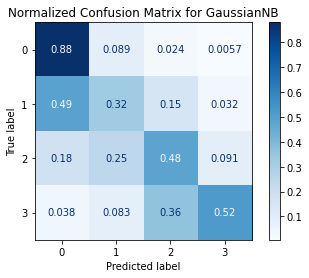

In [169]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
disp = plot_confusion_matrix(gnb, X_test, y_test,display_labels=[0,1,2,3],cmap=plt.cm.Blues,normalize="true")
title = "Normalized Confusion Matrix for GaussianNB"
disp.ax_.set_title(title)

Text(0.5, 1.0, 'Normalized Confusion Matrix for MultinomialNB')

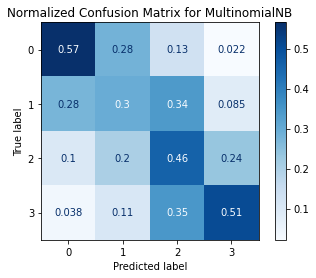

In [170]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
disp = plot_confusion_matrix(mnb, X_test, y_test,display_labels=[0,1,2,3],cmap=plt.cm.Blues,normalize="true")
title = "Normalized Confusion Matrix for MultinomialNB"
disp.ax_.set_title(title)

Text(0.5, 1.0, 'Normalized Confusion Matrix for SVC')

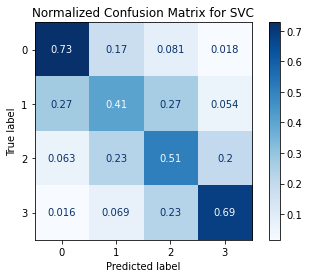

In [171]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
disp = plot_confusion_matrix(svc, X_test, y_test,display_labels=[0,1,2,3],cmap=plt.cm.Blues,normalize="true")
title = "Normalized Confusion Matrix for SVC"
disp.ax_.set_title(title)